# PCA-RF Approach for Stock Trading Signal Detection 

Forecasting trading signals of the stock markets remains one of the most impor-
tant and extremely challenging problems for both investors and researchers. This
is mainly caused by the fact that the stock market is essentially an unstable, non-
linear and complex system, which is affected by many interrelated factors, such as
economic policies, political decrees, the change of company policies, psychological
variables of investors, the future economy. In order to obtain financial
return, financial experts and investors usually analyze the stock market trends by
observing the historical prices data along with economic indicators and make pur-
chase and sale decisions. The benefits involved in predicting trading signals have
motivated researchers to design newer and more advanced tools and prediction
techniques.

This study investigates stock trading signals prediction that is an interesting yet
challenging research topic in the area of financial investment, since the stock market
is an unstable and complex system affected by many interrelated factors and a small
improvement in predictive performance can be profitable. To realize trading signals
detection, several methods have been developed, among which artificial intelligence
methods have drawn more and more attention by both investors and researchers.
In this paper, we propose a complete and efficient method which integrates prin-
cipal component analysis (PCA) into Random Forests (RF)
to forecast trading points of the stock (PCA-RF)

In [1]:
#Import dependencies
import pandas as pd 
import sklearn as sk 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from xgboost import XGBClassifier
from pandas_datareader import data

#Amazon data 
ticker = 'SBIN.NS'
start_date = '2012-01-01'
end_date = '2020-01-29'

data = data.DataReader(ticker, 'yahoo', start_date, end_date)

C:\Users\Sauraj (Work mode)\Miniconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [186]:
data.to_csv("sbi.csv")

## Phase 1: Data Generation and Preprocessing 

Define a stock matrix $S$ which consists of the **Open, High, Low** and **Close** price of the given stock 

$$
S = \begin{bmatrix}
    a_{1} & b_{1} & c_{1} & d_{1}\\
    a_{2} & b_{2} & c_{2} & d_{2}\\
    a_{n} & b_{n} & c_{n} & d_{n}\\
    \end{bmatrix}
$$

Where:  
* $[a_{1}....a_{n}]$ = Vector of Opening prices of length N
* $[b_{1}....b_{n}]$ = Vector of High prices of length N
* $[c_{1}....c_{n}]$ = Vector of Low prices of length N
* $[d_{1}....d_{n}]$ = Vector of Close prices of length N

In [2]:
#Define the matrix from the original data 
data_matrix = data.drop(["Volume", "Adj Close"], axis=1)
data_matrix.describe()

,High,Low,Open,Close
count,1986.000000,1986.000000,1986.000000,1986.000000
mean,253.898754,247.121657,250.712394,250.317402
std,49.128654,48.027511,48.685779,48.532321
min,148.490005,145.270004,147.000000,147.360001
25%,218.322506,212.576252,215.000000,215.567505
50%,257.875000,251.649994,254.899994,254.474998
75%,289.537491,282.200012,286.524994,285.399994
max,373.799988,366.200012,371.950012,372.399994


Next, define the class label $C$ which needs to be predicted. To determine this class label, the **Rate of Change**, $K_{i}$, feature needs to be included in the dataset. 

$$\Delta K_{i} = \frac{K_{i+1}-K_{i}}{K_{i}} * 100$$

$\Delta K_{i}$ is the rate of change of the closing prices of the stock between the $(i+1)^\text{th}$ day and $i^\text{th}$ day. 

For the class labelling, the label rules are determined on the basis of **ROC**, which is calculated from the above formula. 

$$\Delta K_{i} \geq \alpha = 1$$
$$ 0 \leq \Delta K_{i} < \alpha = 2$$
$$ -\alpha \leq \Delta K_{i} < 0 = 3$$
$$ \Delta K_{i} < -\alpha = 4$$

$\alpha$ is defined as the **Threshold Value** which is set under user specific constraints. This threshold value is the trader's decision point at which they would prefer to change their market position and determine their long/short position. Under the current criterion, four trade positions are formulated under two positions:

1. $\kappa$ = Buy position 
2. $\psi$ = Sell Position

$$\kappa_{Strong} = \Delta K_{i} \geq \alpha$$
$$\kappa_{Normal} = 0 \leq \Delta K_{i} < \alpha$$
$$\psi_{Strong} = -\alpha \leq \Delta K_{i} < 0$$
$$\psi_{Normal} = \Delta K_{i} < -\alpha$$

Text(0.5, 1.0, 'ROC of SBI')

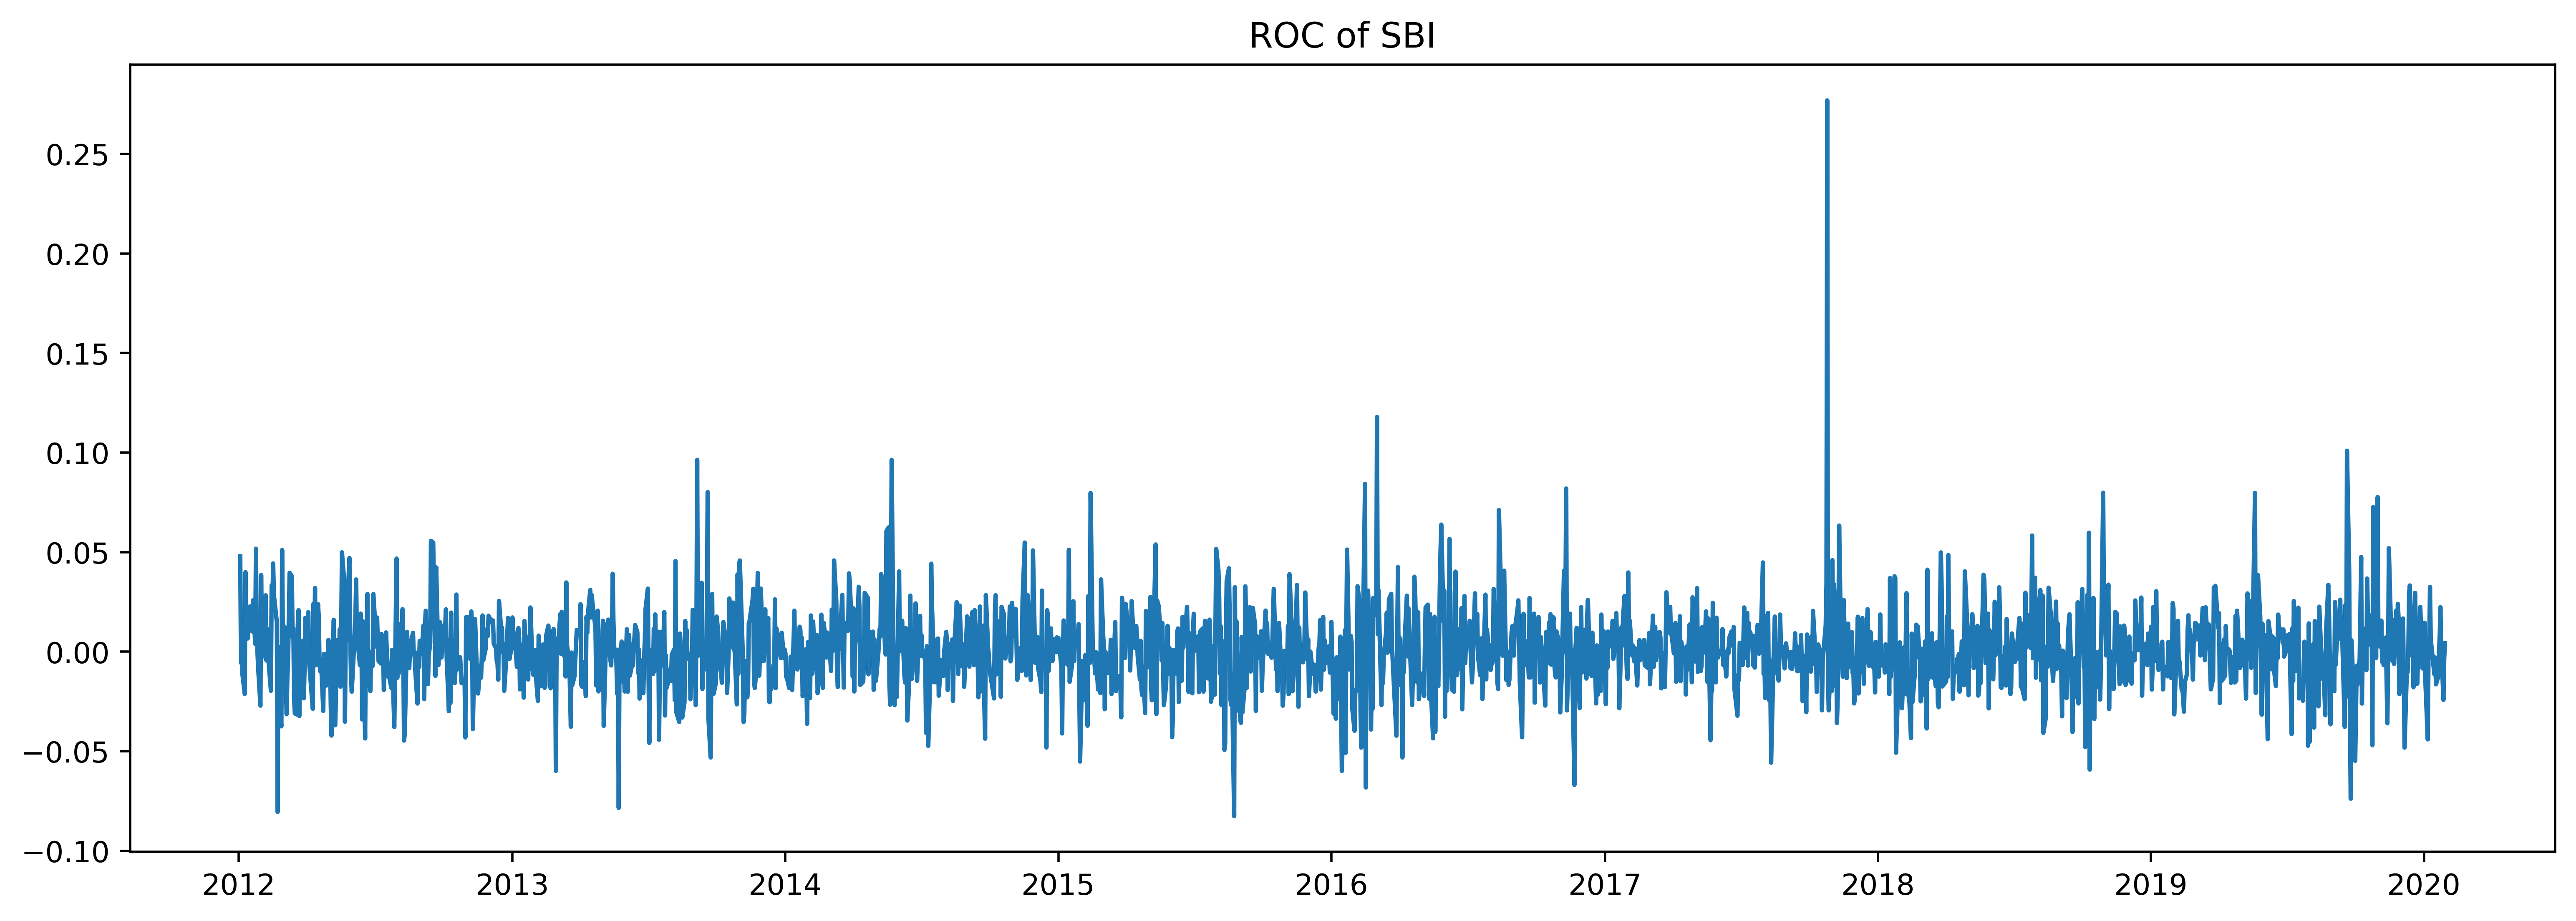

In [3]:
#Generate the trading rules under the specified constraints 
roc = data["Close"].pct_change()
plt.figure(figsize=(15, 5), dpi=500)
plt.plot(roc)
plt.title("ROC of SBI")

The next step is to generate an algorithm that allows us to generate the signals according to numerical classes. 

In [4]:
#Create a function for creating the trade rule generator 
from IPython.core.debugger import set_trace
def rule_generator(rate_of_change, alpha):
    rules = [0]
    for i in range(len(rate_of_change)):
        if rate_of_change[i] >= alpha: #Strong buy 
            rules.append(1)
        elif 0 <= rate_of_change[i] < alpha: #Normal buy 
            rules.append(2) 
        elif -alpha <= rate_of_change[i] < 0: #Normal sell 
            rules.append(3) 
        elif rate_of_change[i] < -alpha: #Strong sell
            rules.append(4) 
            
    return rules
    
#Generate the trade signals and concat them to the data matrix 
signals = rule_generator(roc, 0.03)
data['Signal'] = signals

In [5]:
data['Close'][0] * 0.03

4.882949981689453

#### Input Variable Selection 

In the stock prediction problem, the selection of the input variables is very important since it helps to capture more information about the market variables and help to boost the effectiveness of the model being used. Some of the most commnly used features are technical indicators, with the ones being used for this problem being described below:

1. **Moving Average**: MA is a trend indicator which helps to trace the trend of the asset by smoothing out the series by a the mean value $n$. This indicator is simple to use and is mainly used to determine market trends and crossovers. 

2. **Exponential Moving Average**: EMA is another trend indicator which also helps to determine the trend of the series, except that unlike MA, the EMA gives more weight to the recent observations and follows an exponential decay in the smoothing of the series so that recent points are given more weightage when smoothing the trend. 

3. **Moving Average Convergence Divergence**: A trend following momentum indicator which is used as an indicator for pointing out trend reversals in the market.

4. **On Balance Volume**: OBV is a momentum indicator that measures positive and negative volumne flow to predict changes in the direction of the stock price. 


For this current run, only these four indicators will be chosen.

In [6]:
import ta 
#Indicators to be used for the algorithm,
indicators = {
    "MA": data["Adj Close"].rolling(20).mean(),
    "EMA": ta.trend.EMAIndicator(data["Adj Close"], n=20).ema_indicator(),
    "MACD_line": ta.trend.MACD(data["Adj Close"], n_slow=26, n_fast=12,
                         n_sign=9).macd(),
    "MACD_signal": ta.trend.MACD(data["Adj Close"], n_slow=26, n_fast=12,
                         n_sign=9).macd_signal(),
    "OBV": ta.volume.OnBalanceVolumeIndicator(data["Adj Close"], data["Volume"]).on_balance_volume(),
    "RSI": ta.momentum.rsi(data["Adj Close"]),
    "STOCHASTIC": ta.momentum.stoch(data["High"], data["Low"], data["Adj Close"]),
    "ELDER": ta.volume.force_index(data["Adj Close"], data["Volume"]),
    "ATR": ta.volatility.average_true_range(data["High"], data["Low"], data["Adj Close"]),
    "CCI": ta.trend.CCIIndicator(data["High"], data["Low"], data["Adj Close"]).cci()
    
}

#Adding indicators to the data matrix 
data["MA"] = indicators["MA"]
data["EMA"] = indicators["EMA"]
data["MACD_line"] = indicators["MACD_line"]
data["MACD_signal"] = indicators["MACD_signal"]
data["OBV"] = indicators["OBV"]
data["RSI"] = indicators["RSI"]
data["STOCHASTIC"] = indicators["STOCHASTIC"]
data["ELDER"] = indicators["ELDER"]
data["ATR"] = indicators["ATR"]
data["CCI"] = indicators["CCI"]

#Remove NaN rows
data_new = data.dropna(axis=0)

With the technical indicators added, the new data matrix will be reformulated as follows:

$$
S = \begin{bmatrix}
    a_{1} & b_{1} & c_{1} & d_{1} & T_{1} ... T_{k} & y_{1}\\
    a_{2} & b_{2} & c_{2} & d_{2} & T_{2} ... T_{l} & y_{2}\\
    a_{n} & b_{n} & c_{n} & d_{n} & T_{n} ... T_{m} & y_{3}\\
    \end{bmatrix}
$$

In [7]:
data_new.head()

,High,Low,Open,Close,Volume,Adj Close,Signal,MA,EMA,MACD_line,MACD_signal,OBV,RSI,STOCHASTIC,ELDER,ATR,CCI
Date,,,,,,,,,,,,,,,,,
2012-02-17,247.154999,237.699997,237.699997,241.705002,50345570.0,133.050049,2,117.000825,117.102220,7.240441,6.499806,369407580.0,84.905762,-133.224206,7.790271e+07,96.204761,212.291502
2012-02-21,247.500000,241.500000,242.000000,245.244995,27876680.0,134.998688,2,118.430932,118.806645,7.776356,6.755116,397284260.0,85.906699,-128.336315,7.453398e+07,97.507989,200.545710
2012-02-22,246.910004,223.690002,245.600006,225.500000,63344440.0,124.129745,4,119.296537,119.313607,7.240574,6.852207,333939820.0,61.435489,-150.396273,-3.446903e+07,98.536798,113.880772
2012-02-23,232.309998,224.699997,225.434998,226.050003,44543300.0,124.432510,2,119.901223,119.801122,6.762441,6.834254,378483120.0,61.762245,-180.655582,-2.761829e+07,99.225616,69.918471
2012-02-24,230.300003,219.500000,228.000000,220.559998,36297520.0,121.410461,3,120.307465,119.954392,6.069695,6.681342,342185600.0,56.606594,-232.690129,-3.934323e+07,99.700036,36.240926


Once the new data matrix has been computed, the next phase of the problem is the creation og **training** and **testing** sets altogether in a time-series fashion as shown in the diagram below (Add diagram here later)

The train-test partition will follow a **sliding window approach** since for time-series based problems, the data is not i.i.d in nature and hence needs to be trained in a time-ordered fashion.

In [138]:
# from pandas import DataFrame
# from pandas import concat
 
# def series_to_supervised(data, train_size=1, test_size=1, dropnan=True):

#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = DataFrame(data)
#     cols, names = list(), list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
#     # put it all together
#     agg = concat(cols, axis=1)
#     agg.columns = names
#     # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
#     return agg

For this problem, the training set size will be set at **5** and the testing set size will be set at **1**, since we wish to predict one trading signal at a time.

In [139]:
#Create the new dataset with train_size=5 and test_size=1
# overlapped_dataset = series_to_supervised(data_new, 5, 1)

In [8]:
#Get the train and test sets using TimeSeriesSplit 
from sklearn.model_selection import TimeSeriesSplit
X = data_new.drop("Signal", axis=1).to_numpy()
y = data_new["Signal"]

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Phase 2: Data Normalization and Principal Components Analysis

For the model being created, Principal Component Analysis(PCA) will be used as a dimension reduction technique in order to decompose the original data matrix into a new matrix which is represented by fewer number of vectors projected onto a different subspace, these vectors encapsulating maximal information about the original data through **variance maximization**.

The goal of PCA is to compress the size of the data set by constructing a low-dimensional approximation of the data from the high-dimensional data without losing the most important information and to express this information as a set of new orthogonal variables called principal com-
ponents (PCs).

These principal components (PCs) are the **eigenvectors** of the decomposition which is applied onto the data, with the degree of variance being represented through the eigenvector being shown by its corresponding **eigenvalue**.

Let $X = (x_{1},x_{2},....,x_{n})$, where the data points $x_{i} = (x_{i,1}, x_{i,2},....,x_{i,m})^T \in R^m$ is the $i^\text{th}$ feature vector in the space of dimensios $m$. 

Let $\rho$ denote the correlation matrix of $X$. $\rho$ is a $m\times m$ matrix and the $ij^\text{th}$ element of $\rho$ is computed as:
$$
\rho = \sigma_{x_{i},x_{j}} = E[(x_{i}-E[x_{i}])(x_{j}-E[x_{j}])
$$

$\sigma$ is the **covariance matrix** which measures the variance between two random variables. 

In PCA, each vector in the data matrix needs to be of the same length as PCA is a variance maximizing technique and by scaling the input features within the same scale length, equal weightage is given to each input vector and the differences in the lengths of the original vectors will not allow one of them to have a higher degree of variance than the others. Keeping this in mind, the vectors are standardized to have a zero mean. 

Let the standardized data be denoted by $S$. Hence, the correlation matrix $\rho$ is now defined as:
$$
\rho_{S} = \frac{1}{n}SS^T
$$

$\rho_{S}$ is square symmetric $m\times m$ matrix, with the diagonals representing the variance of the scaled vectors and the off-diagonals representing the covariances. 

Under the PCA problem, the goal is to find a linear mapping $L$ such that it can minimize the redundancy measured by the degree of the covariance and maximize the information gain through the variance. 

Let $Z = LS$ be the mapping matrix. The correlation matrix $\rho_{Z}$ is defined as:

$$
\rho_{Z} = \frac{1}{n}ZZ^T = \frac{1}{n}(LS)(LS)^T = \frac{1}{n}L(SS^T)L^T = P(\frac{1}{n}SS^T)L^T = L(\rho_{S})L^T
$$

Any symmetric matrix can be diagonalized by an orthogonal matrix of its corresponding eigenvectors. The matrix $L$ is one of those symmetric matrices where each row $r_{i}$ is an eigenvector of $\rho_{S}$.

By performing an **eigendecomposition** through:

$$
det(A -\lambda I) = 0
$$

The solution is obtained to provide the eigenvectors and eigenvalues. The principal components of $S$ are the eigenvectors of $\rho_{S}$, with the $i^\text{th}$ diagonal value of $\rho_{Z}$ being the variance of $S$ along eigenvector $k_{i}$. The eigenvalues are produced for each eigenvalue and will be used to rank their corresponding eigenvector according to the amount of variance it explains.

Text(0.5, 0, 'Components')

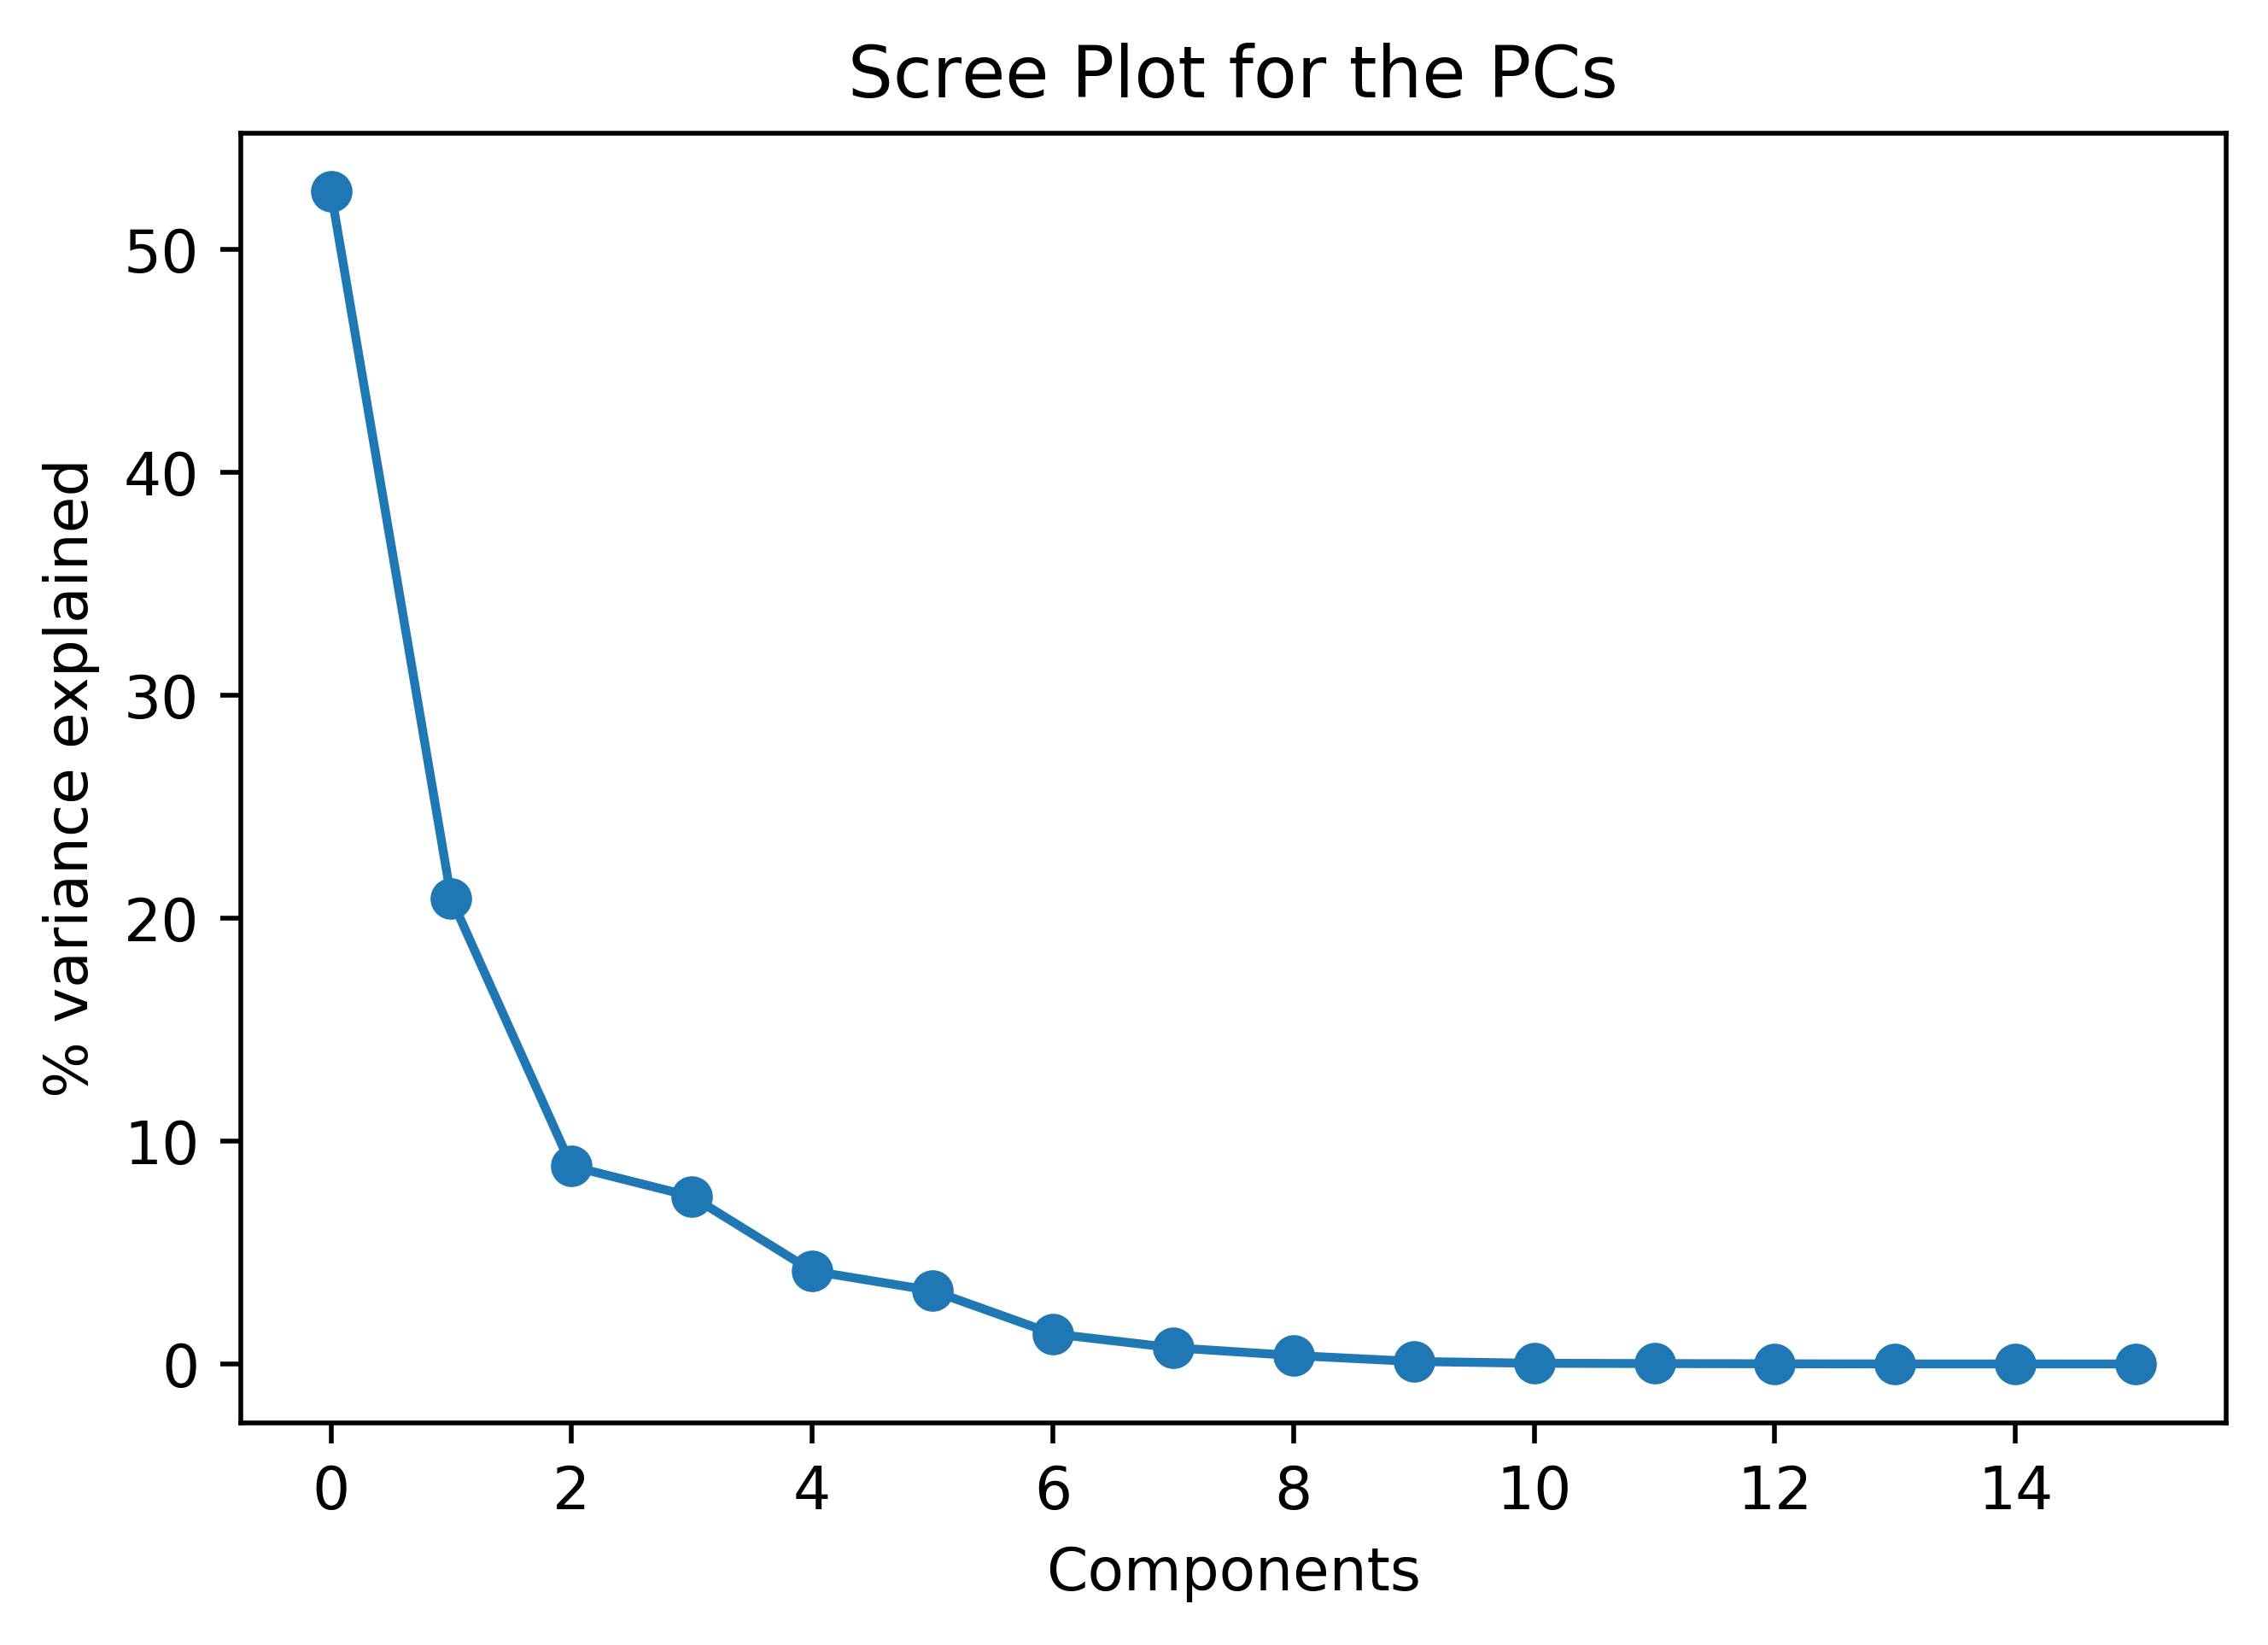

In [9]:
#Apply the PCA transformation with Standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()

phase_2 = Pipeline([("scaler", scaler),("pca", pca)])
pc_components = phase_2.fit_transform(X_train, y_train)
pc_components_test = phase_2.transform(X_test)

#Extract the variance explained ratio for each principal component 
plt.figure(dpi=500)
plt.plot(phase_2["pca"].explained_variance_ratio_*100, "-o")
plt.title("Scree Plot for the PCs")
plt.ylabel("% variance explained")
plt.xlabel("Components")

A total of 3 components explain more than 95% variance in the dataset, hence we only choose the **first 3 principal eigenvectors**

Text(0.5, 1.0, 'Principal Components Plot')

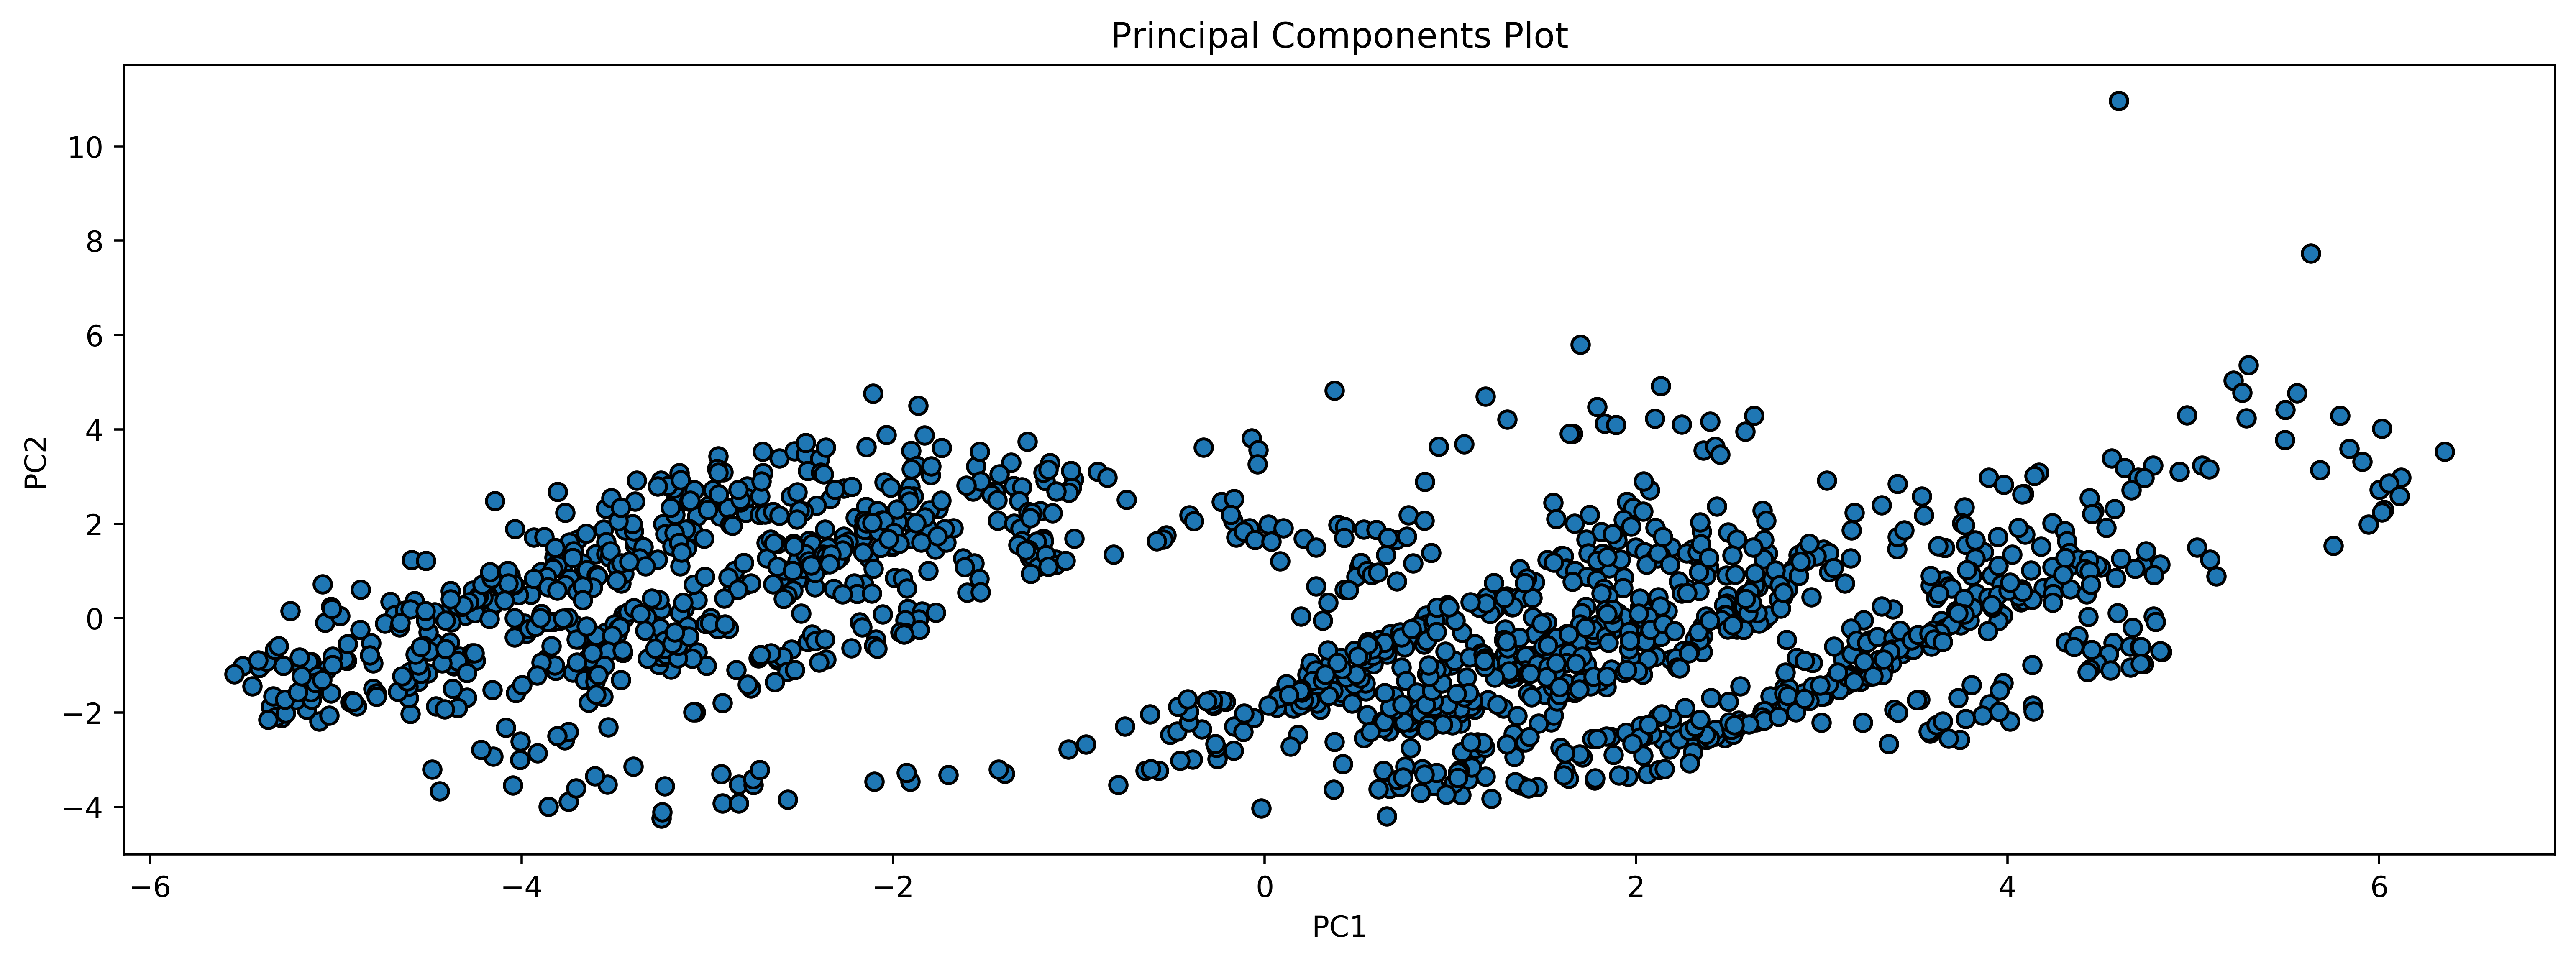

In [10]:
#Observing the principal components as a cluster 
plt.figure(figsize=(15, 5), dpi=500)
plt.scatter(pc_components[:, 0], pc_components[:, 1], edgecolor='black')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Principal Components Plot")

Let's extract the eigenvalues and the eigenvectors for the Principal Components

In [11]:
#Principal components and explained variance by each eigenvector 
eigenvecs = phase_2["pca"].components_
eigenvalues = phase_2["pca"].explained_variance_

## Phase 3: Decomposing classes into multiclass classification for Random Forests training

Because SVM's are used for binary classification, traditional SVM's are not useful for multiclass classification problems. A workabout around this is to convert the decision function to either **One-versus-One (OVO)** or to **One-versus-Rest (OVR)** classification. 

For this problem, the decision function will be kept at **OVO** as it is much more accurate and is good for small sized datasets. Under the OVO decision function, the multinomial classes are split into $k(k-1)/2$ separate binary classification problems.

In [12]:
#Fitting the random forests model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, make_scorer
from random import seed 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#Precision scorer for multiclass classification
scorer = make_scorer(precision_score, average = 'macro')

#Parameter tables
params = {
    "n_estimators" : np.linspace(2, 100, 100, dtype = "int")
}
scorers = {"precision":"precision"}
#Instantiate the model and run search.
rfr = RandomForestClassifier(n_estimators=100)
rfr.fit(pc_components, y_train)

preds = rfr.predict(pc_components_test)
accuracy_score(preds, y_test)

0.7569230769230769

In [13]:
#Let's get the best parameter settings for Random Forests 
rfr_optimized

NameError: name 'rfr_optimized' is not defined

With the grid search enabled, the random forests model gives a total of 77.23% accuracy on the test set for the classified variables. Let's see the classification summary using a confusion matrix and summary statistics for the classification scores. 

For assessing the classification accuracy for this model and the overall model performance, we use four different metrics:

1. **Balanced Accuracy Score**: Helps to determine the classification accuracy of the model under imbalanced class settings 
2. **ROC-AUC**: The ROC curve will help to gauge the predictive power of the model under different TP/FP settings, and the AUC will gauge how well the model performs for each class group
3. **Precision-Recall**: The PR curve will tell the model's ability to trace a specific signal and to accurately label it as the specified signal.
4. **Confusion Matrix**: The confusion matrix will help to tell us the ratio of true positives to false positives, and true negatives to false negatives. 

In [14]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, classification_report
#Model accuracy 
accuracy = balanced_accuracy_score(preds, y_test)
print("Accuracy of the model under class imbalance: {}".format(accuracy))

Accuracy of the model under class imbalance: 0.8138543879090098


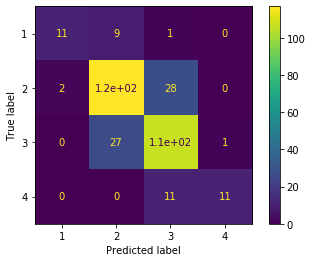

In [15]:
#Confusion matrix 
plot_confusion_matrix(rfr, pc_components_test, y_test)

In [16]:
#Classification report 
print(classification_report(y_test, preds, target_names=["Strong Buy", "Normal Buy","Normal Sell","Strong Sell"]))

              precision    recall  f1-score   support

  Strong Buy       0.85      0.52      0.65        21
  Normal Buy       0.76      0.80      0.78       147
 Normal Sell       0.73      0.79      0.76       135
 Strong Sell       0.92      0.50      0.65        22

    accuracy                           0.76       325
   macro avg       0.81      0.65      0.71       325
weighted avg       0.76      0.76      0.75       325



In [17]:
prices = data["Close"][len(data)-len(y_test):]

In [18]:
lolz = pd.DataFrame([np.array(prices), preds, y_test]).T
close_preds = lolz.rename(columns={0:"Close", 1:"preds", 2:"actual"})

In [19]:
close_preds

,Close,preds,actual
0,265.500000,3.0,2.0
1,273.850006,2.0,1.0
2,271.700012,3.0,3.0
3,271.350006,2.0,3.0
4,258.350006,4.0,4.0
...,...,...,...
320,323.200012,2.0,2.0
321,324.049988,2.0,2.0
322,316.200012,3.0,3.0
323,315.100006,3.0,3.0


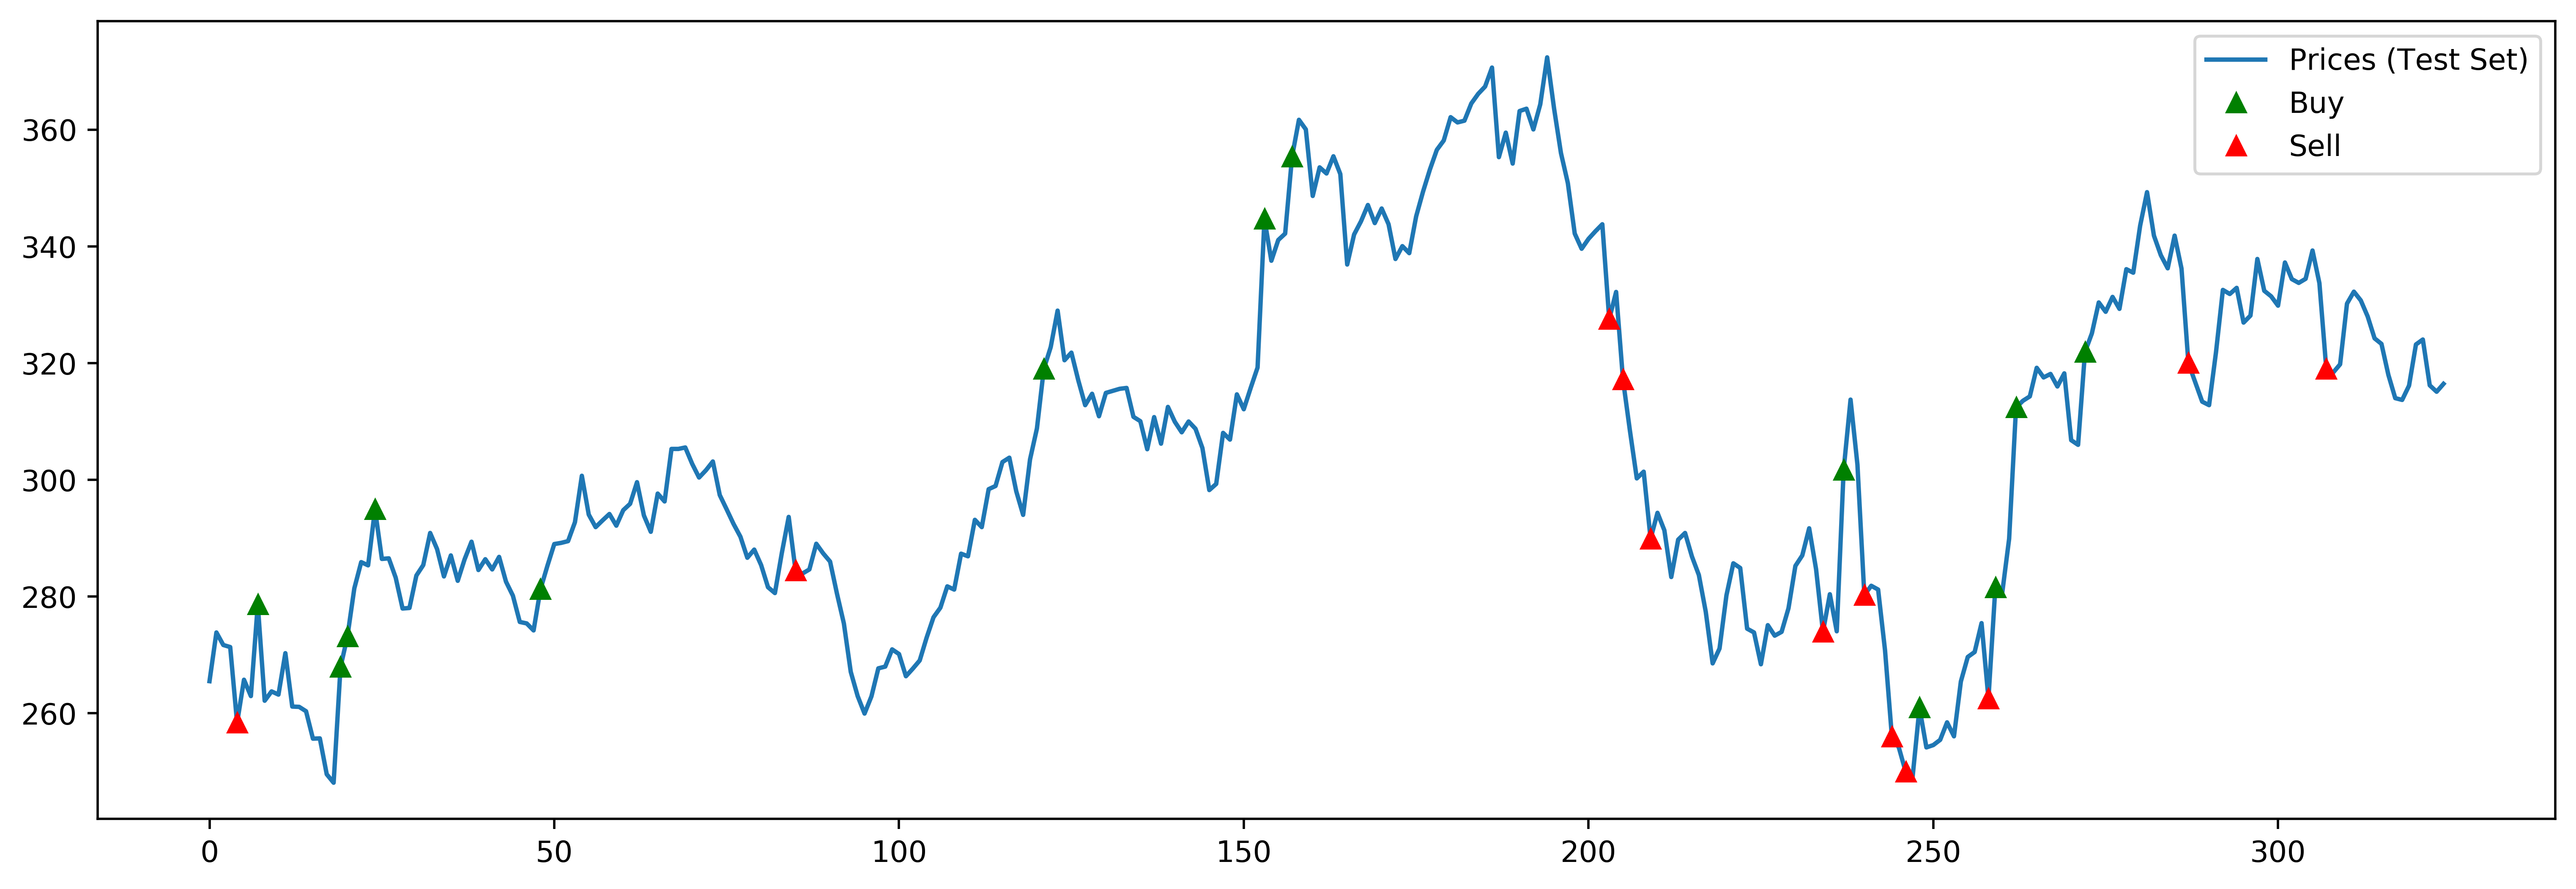

In [20]:
plt.figure(figsize=(15, 5), dpi=500)
plt.plot(close_preds["Close"], label="Prices (Test Set)")
plt.plot(close_preds["Close"], '^', label="Buy", markevery=close_preds[close_preds["preds"] == 1].index.tolist(), c='g')
plt.plot(close_preds["Close"], '^', label="Sell", markevery=close_preds[close_preds["preds"] == 4].index.tolist(), c='r')
plt.legend()

#### What do the above metrics mean in terms of signal detection and trading strategies?

1. Looking at the classification report, the optimized random forest model has a good precision score of 0.74 for detecting a strong buy signal and a good recall score of 0.82. For trade strategies where long positions matter, the model does a good job in detecting bullish signals easily. Though this might infer that the model is great at detecting bullish signals for trading, it should be noted that the out-of-sample data should not be taken heavily into consideration as to whether the model is optimal for picking bullish strategies that include holding long positions.

2. The normal buy signal has a precision score of 0.80 and a recall score of 0.75, giving a total precision/recall ratio of 1.067. For trading strategies where buying positions can matter, the optimized model does a decent job of detecting buy positions and has a good precision rate of pinpointing the true buy signals. Does this mean that the model is good enough for tracing the correct buying position? Not really as despite having a good precision score, the classifier tends to misclassify buy positions as strong sell positions, something which is usually observed during short selling strategies. Hence the model can do a decent job at picking simple buy strategies and short selling strategies. 

3. The strong sell signal with a recall rate of 0.75 and does a good job at detecting strong sell signals with a good precision score of 1.00. Bearish markets are indicative of a strong sell position and is usually observed when declines outweigh advances in a given trading session. For a trading strategy where bearish regime can prevail, the model does a great job on detecting those trade signals on out-of-sample dataset. But again, caution should be taken as the model is not a definite indicator of a strong bear position and how the classifier detects such signals is completely dependent upo how the strategy is devised. 

**It should be noted that though these metrics on the out-of-sample data seem good, every trade strategy is highly user dependent and the output values we wish to see can change depending upon the position, timing, regime and risk/reward ratio, along with the data we use and the strategy we entail in the algorithm. Hence every output seen here should be taken with a grain of salt unless and until backtesting and in-depth strategy testing have not been performed**

## Performance Measure and Trading Simulation 

Now that the algorithm has been coded and modelled, the next step is to run it and check's its viability for being able to generate profits. For the performance measurement, two different strategies will be tested 

Let: 
$$
b_{stock}(i): \text{Balance number of shares for the i_{th} day in the portfolio}
$$
$$
v_{money}(i): \text{Total investment money until i_th day in the portfolio}
$$

1. **Long position buy/sell at Strong signals**: If the trade signal generates a _strong buy_ position, purchase 100 shares with $Need_{i} = 100 \times (Avg_{i} \times (1 + c_{buy}))$ of the funds in the portfolio. 

2. **Long position buy/sell at all signals**: For each trade signal generated, produce the buy/sell operation

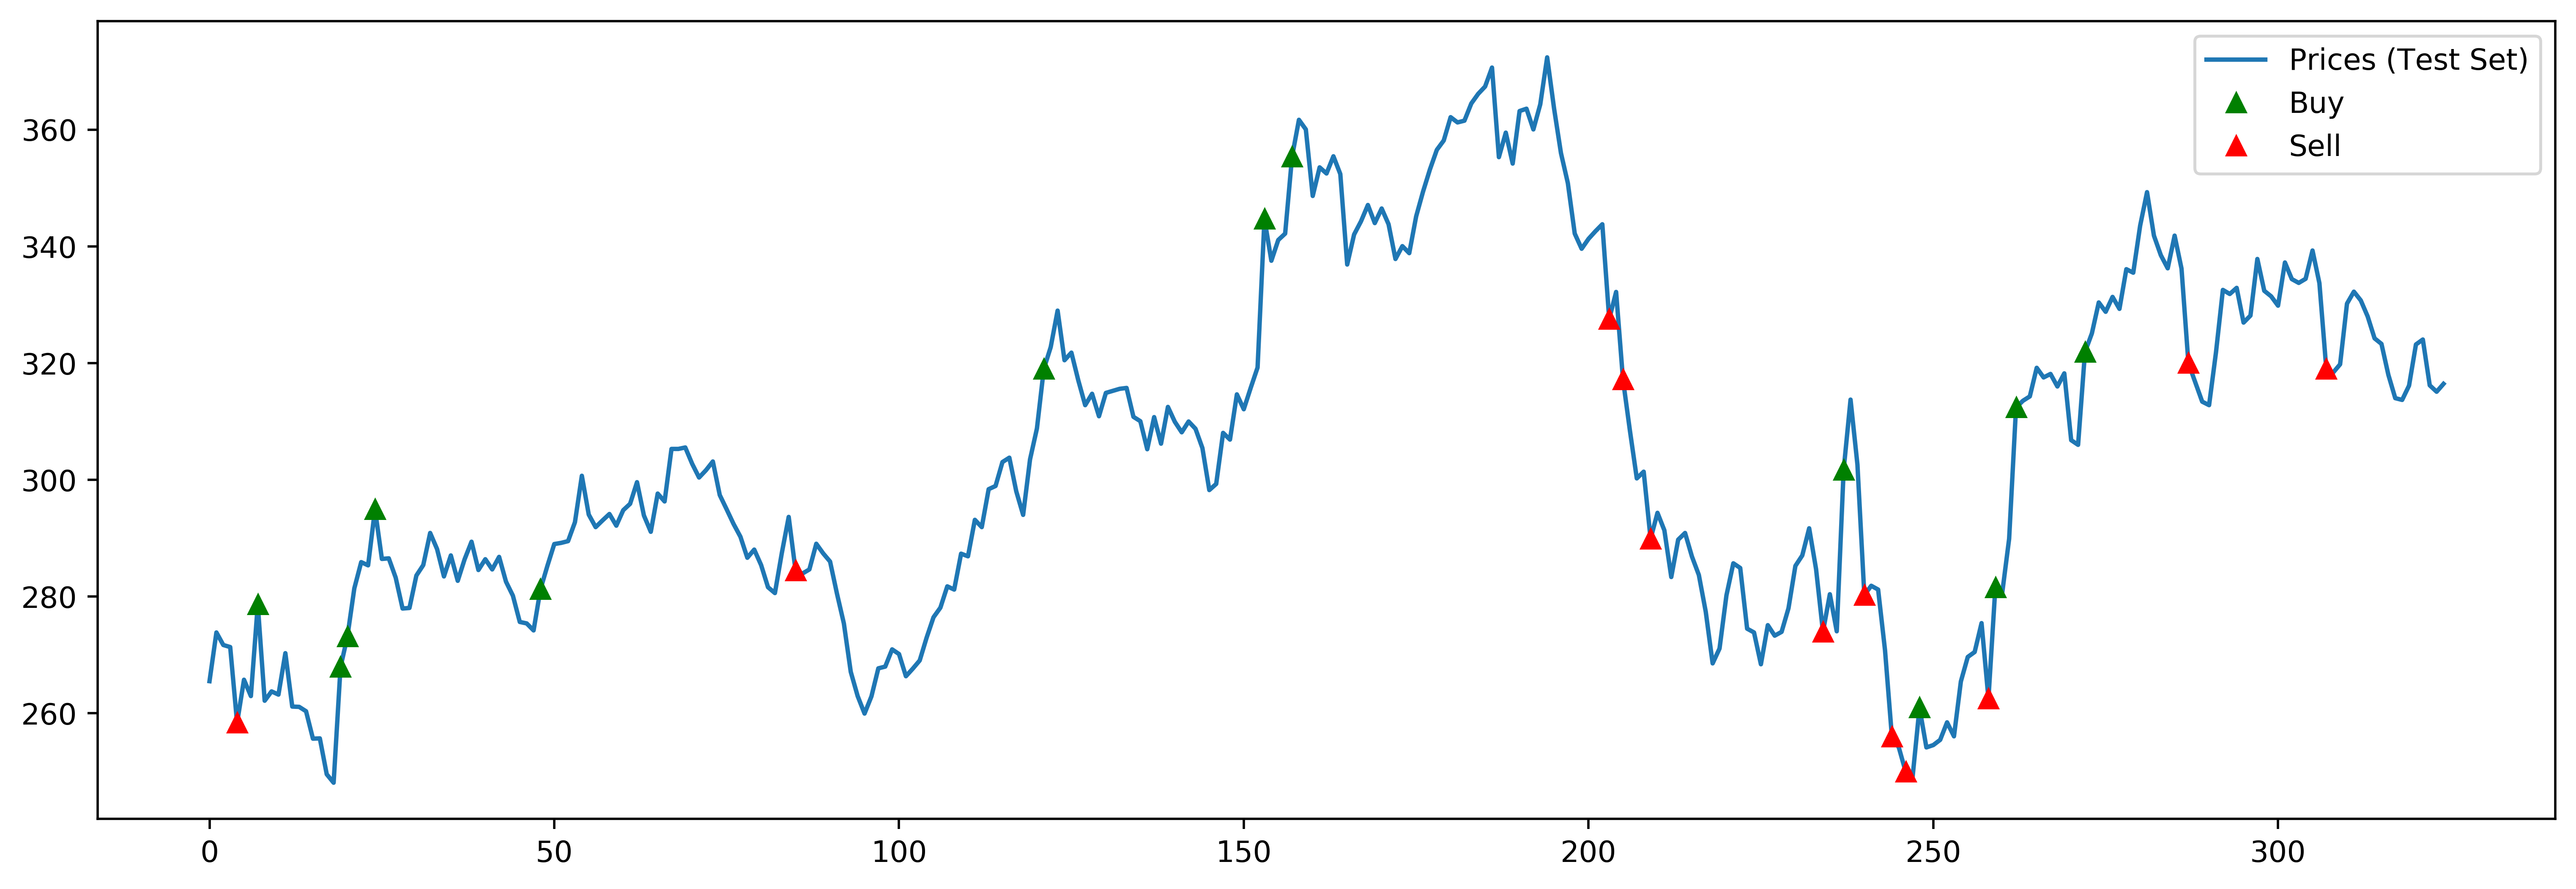

In [21]:
plt.figure(figsize=(15, 5), dpi=500)
plt.plot(close_preds["Close"], label="Prices (Test Set)")
plt.plot(close_preds["Close"], '^', label="Buy", markevery=close_preds[close_preds["preds"] == 1].index.tolist(), c='g')
plt.plot(close_preds["Close"], '^', label="Sell", markevery=close_preds[close_preds["preds"] == 4].index.tolist(), c='r')
plt.legend()

### Strategy: Long Position for all Buy/Sell

Under this strategy, the stocks are bought and sold at each signal

In [22]:
close_preds

,Close,preds,actual
0,265.500000,3.0,2.0
1,273.850006,2.0,1.0
2,271.700012,3.0,3.0
3,271.350006,2.0,3.0
4,258.350006,4.0,4.0
...,...,...,...
320,323.200012,2.0,2.0
321,324.049988,2.0,2.0
322,316.200012,3.0,3.0
323,315.100006,3.0,3.0


In [23]:
"""
Cluttered code snippet. Can be made much more OOP and cleaned to read and reuse.
"""

def trader(signal_predictions):
    shares = [0] #Share quantity
    net_worth = [10000] #Net worth of account 
    equity = [10000] #Total equity capital being traded
    transaction_costs = [0] #Transaction cost each trade
    commission = 0.03 #Commission rate
    tax_rate = 0.025 #Tax rate only charged during selling
    close = signal_predictions['Close']
     #The predicted signals along with closing prices
    net_gain = [close[i+1] - close[i] for i in range(len(close)-1)]

    for price, signal, index in zip(close, close_preds['preds'], range(len(close)-1)):

        if signal == 1: #Strong buy 
            transaction_cost = 100 * (price * (1+commission)) #Transaction cost of 10 shares
            transaction = 100 * price #Cost of 10 shares (excluding commission)

            transaction_costs.append(transaction_cost) #Transaction cost including commission 
            gain = (net_gain[index]*100) - (net_gain[index]*100*commission)
            equity.append(equity[index]+gain) #Update equity size 
            net_worth.append(net_worth[index] - transaction_cost) #Update portfolio net worth 
            shares.append(shares[index]+100) #Increment 10 shares in portfolio    

        if signal == 2: #Normal buy 
            transaction_cost = 50 * (price * (1+commission))
            gain = (net_gain[index]*50) - (net_gain[index]*50*commission) 
            equity.append(equity[index]+gain)
            net_worth.append(net_worth[index] - transaction_cost)
            shares.append(shares[index]+50)

        if signal == 3:
            transaction_cost = 50 * (price * (1+commission)) * (1 + tax_rate)
            gain = (net_gain[index]*50) - (net_gain[index]*50*commission)-(net_gain[index]*tax_rate*50)
            equity.append(equity[index] + gain)
            net_worth.append(equity[index] + (net_gain[index]*50))
            shares.append(shares[index]-50)


        if signal == 4:
            transaction_cost = shares[index] * (price * (1+commission)) * (1+tax_rate)#Sell all shares

            transaction_costs.append(transaction_cost)
            gain = (net_gain[index]*shares[index]) - (net_gain[index]*commission*shares[index])-(net_gain[index]*tax_rate*shares[index])
            equity.append(equity[index] + gain)
            net_worth.append(equity[index] + (net_gain[index]*shares[index]))
            shares.append(shares[index]-shares[index])
            
    return equity, shares, transaction_costs


In [24]:
#Obtain the equity, shares and the transaction cost
equity, shares, t_costs = trader(close_preds)

Text(0, 0.5, 'Change in Equity Capital')

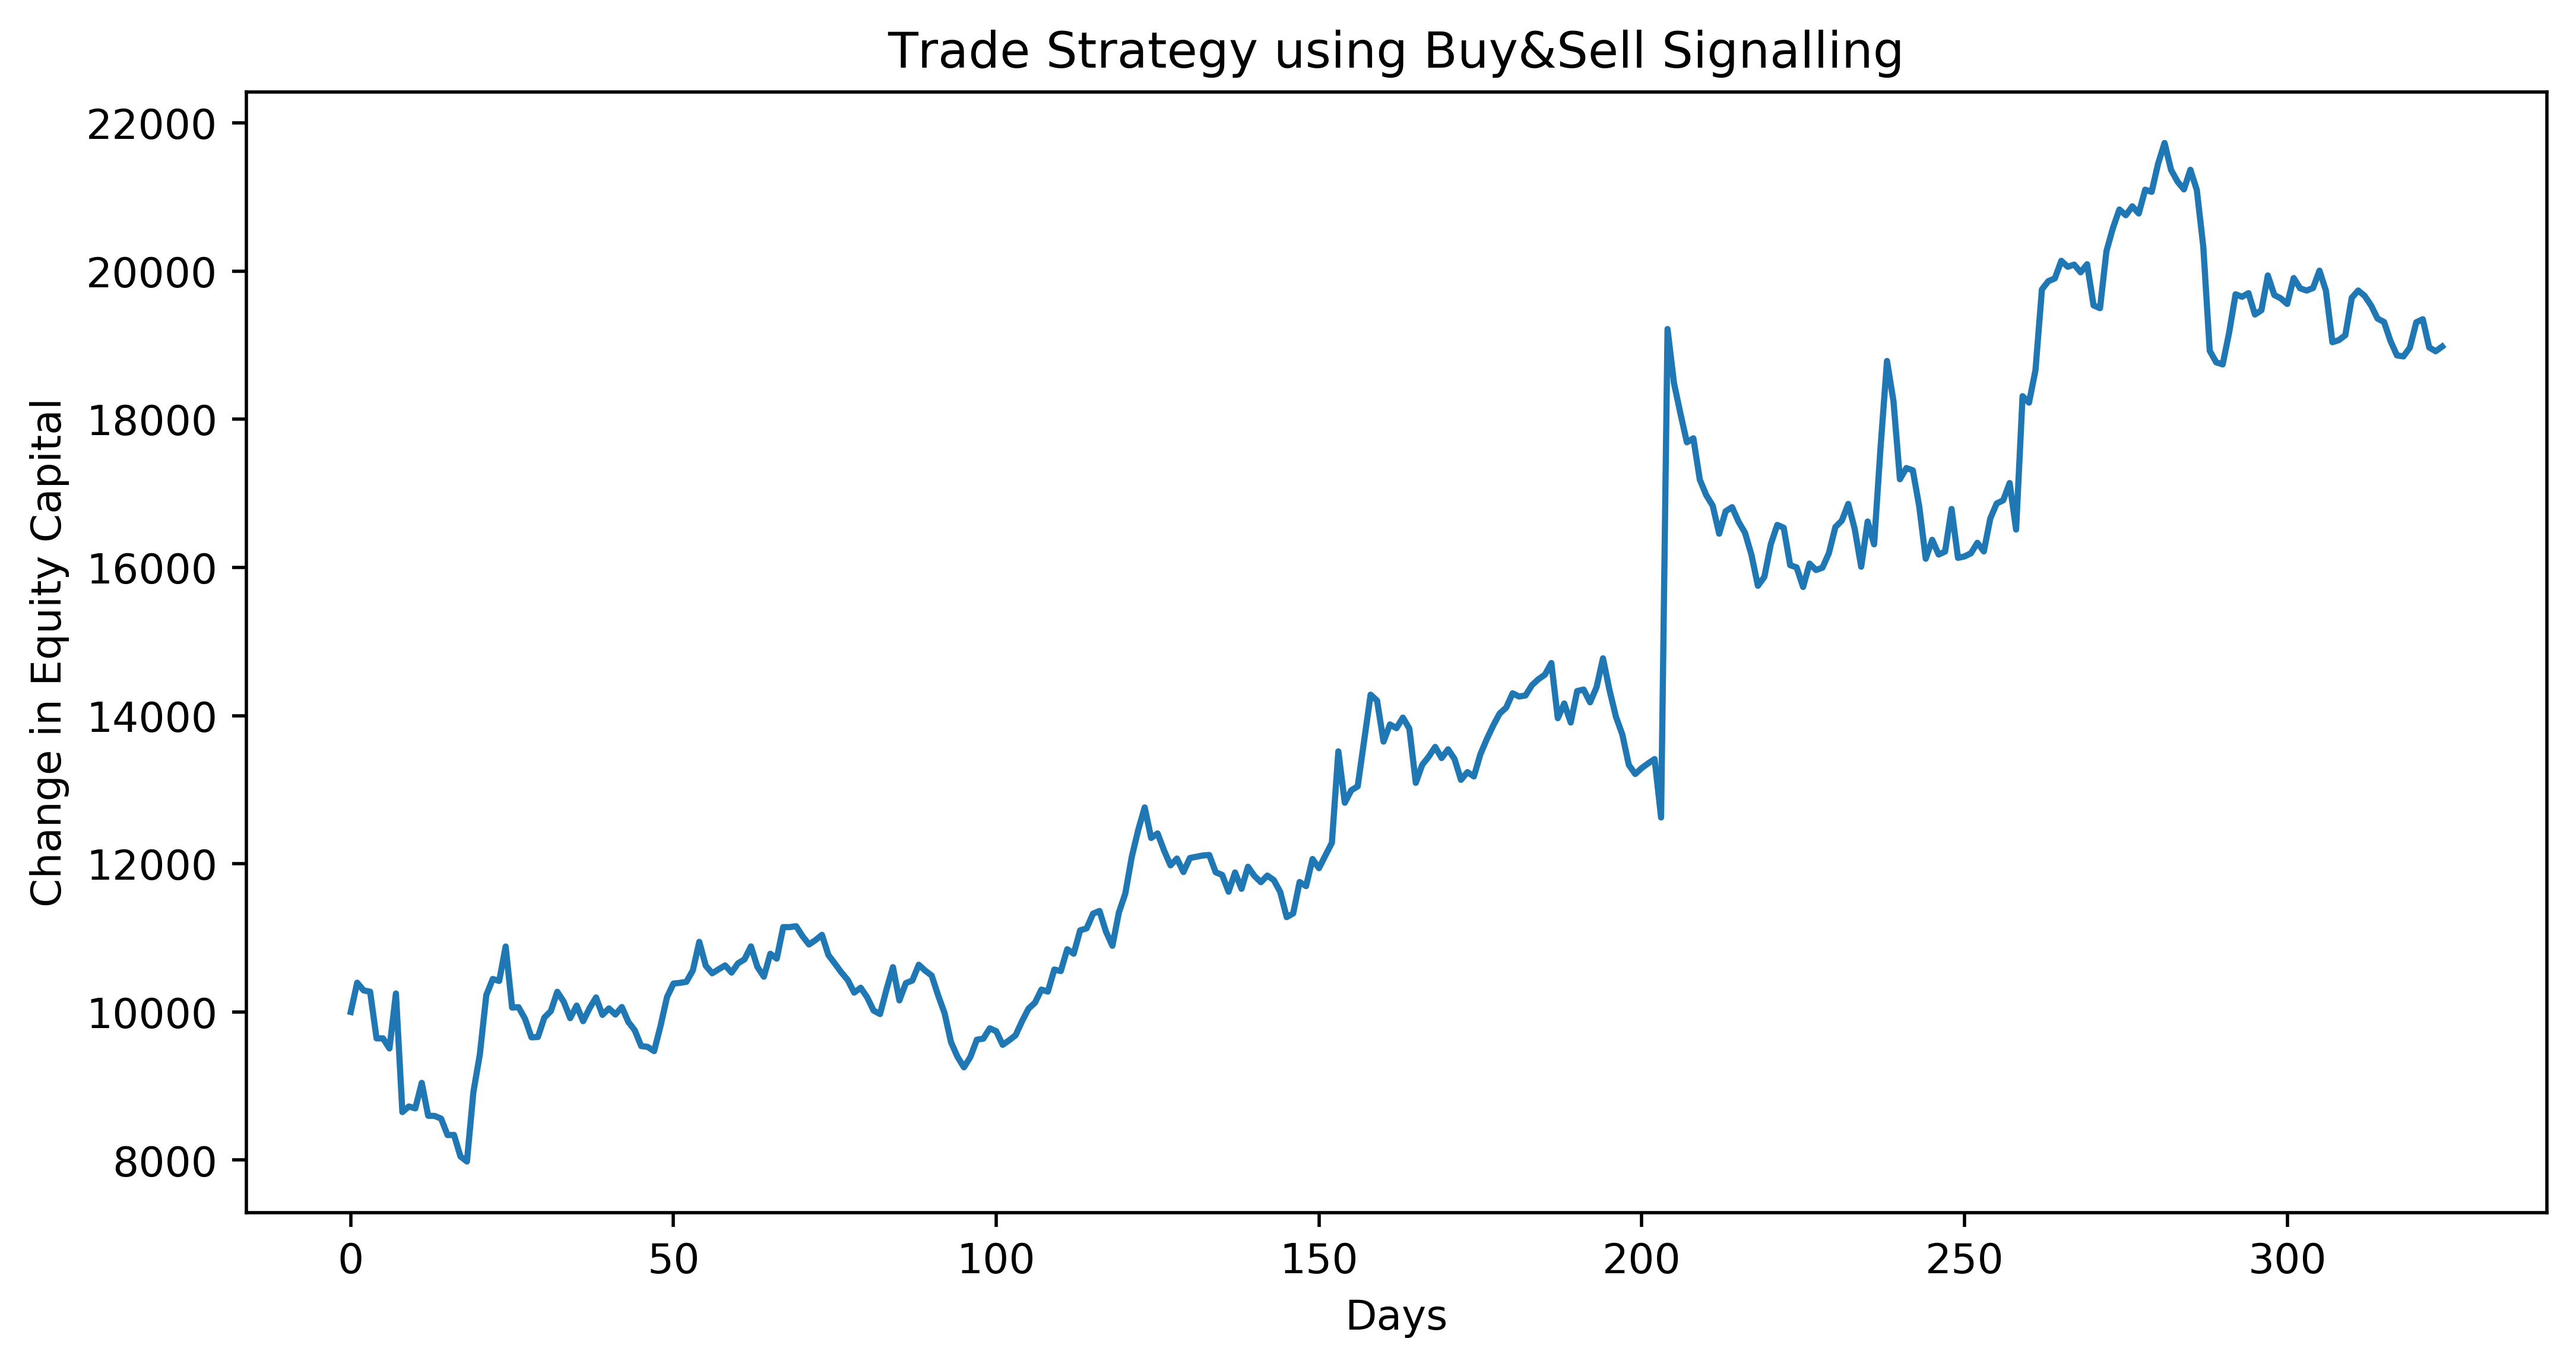

In [25]:
plt.figure(figsize=(10,5), dpi=500)
plt.plot(equity)
plt.title("Trade Strategy using Buy&Sell Signalling")
plt.xlabel("Days")
plt.ylabel("Change in Equity Capital")

In order to assess the profitability of the above strategy, two important metrics will be used to asses the performance:

1. Sharpe Ratio 
2. Drawdown Rate 


The **Sharpe Ratio** is one of the most commonly used metrics in algorithmic trading and investments as it tells the **amount of returns earned on an investment for each incremental increase in risk**. The Sharpe ratio is defined as:

$$
S_{a} =  \sqrt{days} \frac{E[R_{equity} - R_{f}]}{\sigma_{equity}}
$$

The ratio is multiplied by 252 as it represents the total number of trading days in a year. The Sharpe Ratio will help to gauge the overall performance of the stock against a relative benchmark, usually being the market index as it represents the optimal portfolio of securities which can provide the best returns possible.


The **Drawdown Rate** is the measure of the decline from a historical peak in some variable.

If $X(t), t \geq 0$ is a stochastic process with $X(0) = 0$, the drawdown at time $T$, denoted by $D(T)$, is defined as:

$$
D(T) = max[max (X(t) - X(T), 0], t \in (0,T)
$$

In [26]:
#Define the two functions

def sharpe_ratio(returns):
    """
    Calculates the Sharpe Ratio of the equity
    """
    returns = pd.Series(returns)
    pct_returns = returns.pct_change()
    
    sharpe = np.sqrt(len(close_preds)) * (pct_returns.mean() / pct_returns.std())
    return sharpe


def drawdown(returns):
    
    peak, trough = max(returns), min(returns)
    drawdown = (peak-trough)/peak * 100 
    return drawdown
    

In [27]:
sharpe = sharpe_ratio(equity)
drawdown = drawdown(equity)
print("Annualized Sharpe: {}".format(sharpe))
print("Drawdown: {}%".format(round(drawdown)))

Annualized Sharpe: 1.2149485838447815
Drawdown: 63.0%


Let's see how well this strategy performs on SBI data, and along with that, we shall also include 4 more stocks from the NSE such as:

1. Infosys **INFY.NS** 
2. RELIANCE **RELIANCE.NS**
3. Cipla **CIPLA.NS** 
4. Tata Consultancy Services **TCS.NS**

The code snippet has been attached in the folder's repository

In [28]:
from pandas_datareader import data
symbols = ['INFY.NS','RELIANCE.NS','CIPLA.NS','TCS.NS']
start_date = '2012-01-01'
end_date = '2020-01-29'

def fetch_data(ticker):
    if type(ticker) is not str:
        raise ValueError("'ticker' variable needs to be in string format.")
    
    return data.DataReader(ticker, 'yahoo', start_date, end_date)

In [29]:
infy = fetch_data('INFY.NS')
reliance = fetch_data('RELIANCE.NS')
cipla = fetch_data('CIPLA.NS')
tcs = fetch_data('TCS.NS')

In [54]:
data =[infy, reliance, cipla, tcs]

for datas in data:
    datas = datas['Close'].pct_change()

In [55]:
infy

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,352.080994,342.750000,344.899994,351.118988,5826176.0,166.445450
2012-01-03,360.868988,352.500000,353.013000,358.037994,8903008.0,169.725327
2012-01-04,359.375000,355.131012,355.625000,356.799988,7341424.0,169.138458
2012-01-05,359.500000,353.931000,354.899994,355.019012,7125272.0,168.294235
2012-01-06,358.450012,351.388000,354.750000,354.019012,7087632.0,167.820145
...,...,...,...,...,...,...
2020-01-23,785.500000,776.700012,777.099976,784.349976,12528017.0,784.349976
2020-01-24,786.500000,773.599976,775.750000,782.750000,7540490.0,782.750000
2020-01-27,784.799988,774.400024,779.049988,778.099976,3741610.0,778.099976
